In [1]:
import tensorflow as tf
import tensorflowjs as tfjs
import pandas as pd
import numpy as np

import seaborn as sns
import datetime

# from collections.abc import Mapping

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [5]:
pd.read_pickle("rena_closed_2")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1711.0,-122.558594,-40.039062,13.149821,-6.269368,-0.490540,0.172791,0.870483,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.648926e+09,0.0
1,1711.0,-65.429688,-76.171875,11.678924,-5.310047,-0.490540,0.172791,0.870483,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.648926e+09,0.0
2,1711.0,10.742188,-40.039062,6.917573,-4.593633,-0.490540,0.172791,0.870483,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.648926e+09,0.0
3,1711.0,79.101562,445.312500,-0.179759,-4.120129,-0.490540,0.172791,0.870483,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.648926e+09,0.0
4,1711.0,43.294271,445.312500,-7.339966,-3.889533,-0.482422,0.151733,0.876587,-113.291304,2.796024,79.529688,0.0,0.0,0.0,1.648926e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,1919.0,-23.274740,-662.597656,-155.355312,-15.967381,-0.472656,0.125977,0.886353,-4.470648,2.414748,2.384844,0.0,0.0,0.0,1.648926e+09,0.0
2504,1919.0,44.270833,-57.617188,-162.302074,-18.537983,-0.474121,0.129944,0.889099,-4.522980,2.519412,2.354940,0.0,0.0,0.0,1.648926e+09,0.0
2505,1919.0,20.996094,-57.617188,-164.567632,-22.244300,-0.474121,0.129944,0.889099,-4.522980,2.519412,2.354940,0.0,0.0,0.0,1.648926e+09,0.0
2506,1919.0,-54.361979,-638.183594,-163.356404,-24.698532,-0.474121,0.129944,0.889099,-4.522980,2.519412,2.354940,0.0,0.0,0.0,1.648926e+09,0.0


In [6]:
## Compile and prepare the dataset
people_names = ["jack", "karuna", "rena"]
eye_status = ["open", "closed"]


full_dataset = []
labels = []

for people in people_names:
    for status in eye_status:
        file_prefix = people + "_" + status + "_"
        for idx in range(1, 3):
            file_name = file_prefix + str(idx)
            df = pd.read_pickle(file_name)

            features = df[[1, 2, 3, 4]].to_numpy()
            full_dataset.append(features)
            # assert features.shape == (2532, 4), f"{features.shape} is not correct from {file_name}"
            labels.append(1 if status == "closed" else 0)


<AxesSubplot:>

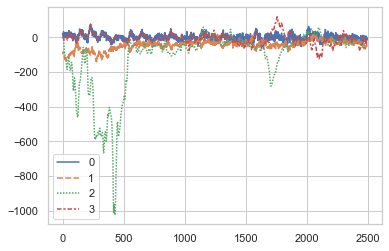

In [7]:
sns.lineplot(data=pd.DataFrame(full_dataset[3]))

In [8]:
## construct dataset for tf
WIDTH = 600
NUM_INPUTS = 4 * WIDTH
NUM_SAMPLES_FROM_INDIV = 30

sampled_dataset = np.zeros((NUM_SAMPLES_FROM_INDIV * len(people_names) * 2 * 2, WIDTH, 4))
sampled_labels = np.zeros((NUM_SAMPLES_FROM_INDIV * len(people_names) * 2 * 2))
counter = 0

for idx_data in range(len(full_dataset)):
    dataset_to_sample = full_dataset[idx_data]
    label = labels[idx_data]

    for idx in range(NUM_SAMPLES_FROM_INDIV):
        start_time = np.random.randint(0, len(dataset_to_sample) - WIDTH)
        feature_to_add = dataset_to_sample[start_time:start_time+WIDTH]

        sampled_dataset[counter] = feature_to_add
        sampled_labels[counter] = label
        counter += 1


In [9]:
## Prepare model
## assume the input comes as (4, WIDTH) matrix

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape = (4, WIDTH)),
#     tf.keras.layers.Dense(NUM_INPUTS),
#     tf.keras.layers.Dense(2 * NUM_INPUTS),
#     tf.keras.layers.Dense(NUM_INPUTS),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(100),
#     tf.keras.layers.Dense(2)
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(100, 250, input_shape=(WIDTH, 4), activation='sigmoid'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(80, 30, activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(60, 10, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(2)
])

model.summary()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 351, 100)          100100    


2022-04-02 18:42:01.784481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 max_pooling1d (MaxPooling1D  (None, 175, 100)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 80)           240080    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 73, 80)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 60)            48060     
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 500)               1920500   
                                                                 
 dense_1 (

In [10]:
## Perform inference
## perform some validation

TRIALS = 5

validation_dataset = np.zeros((len(full_dataset) * TRIALS, WIDTH, 4))
validation_labels = np.zeros((len(full_dataset) * TRIALS))
counter = 0

## for each file
for idx_data in range(len(full_dataset)):
    dataset_to_sample = full_dataset[idx_data]
    label = labels[idx_data]
    for _ in range(TRIALS):

        ## choose a random position
        start_time = np.random.randint(0, len(dataset_to_sample) - WIDTH)

        ## get 300 points
        feature = dataset_to_sample[start_time:start_time+WIDTH]
        validation_dataset[counter] = feature
        validation_labels[counter] = label

        counter += 1


In [11]:
## Train model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(x=sampled_dataset, y=sampled_labels, batch_size=10, epochs=6, 
          validation_data=(validation_dataset, validation_labels), 
          callbacks=[tensorboard_callback])


Epoch 1/6
36/36 [==============================] - 8s 187ms/step - loss: 2.2403 - accuracy: 0.5389 - val_loss: 0.6791 - val_accuracy: 0.6333
Epoch 2/6
36/36 [==============================] - 6s 164ms/step - loss: 0.4834 - accuracy: 0.7639 - val_loss: 0.9746 - val_accuracy: 0.6333
Epoch 3/6
36/36 [==============================] - 6s 155ms/step - loss: 0.4487 - accuracy: 0.7750 - val_loss: 0.4033 - val_accuracy: 0.7833
Epoch 4/6
36/36 [==============================] - 6s 157ms/step - loss: 0.6709 - accuracy: 0.7972 - val_loss: 1.5564 - val_accuracy: 0.4333
Epoch 5/6
36/36 [==============================] - 6s 168ms/step - loss: 0.6179 - accuracy: 0.7167 - val_loss: 0.5457 - val_accuracy: 0.7333
Epoch 6/6
36/36 [==============================] - 6s 160ms/step - loss: 0.6423 - accuracy: 0.7833 - val_loss: 0.5723 - val_accuracy: 0.6833


In [12]:
len(sampled_dataset)

360

In [13]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 50178), started 2:30:16 ago. (Use '!kill 50178' to kill it.)

In [14]:

## check the model's performance
model.evaluate(validation_dataset, validation_labels)

2/2 [==============================] - 0s 139ms/step - loss: 0.5723 - accuracy: 0.6833


[0.572323739528656, 0.6833333373069763]

In [15]:
model.predict(validation_dataset)

array([[ 9.28090811e-02, -1.99805424e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [ 2.75627859e-02, -6.99232221e-02],
       [ 3.65506895e-02, -7.57724941e-02],
       [ 4.53415774e-02, -8.08392614e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [ 6.57732412e-02, -6.81801587e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [ 5.84293492e-02, -5.46653308e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [ 6.84991851e-02, -5.97176105e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [ 6.19018637e-02, -6.36784956e-02],
       [-6.01326764e-01,  1.43736088e+00],
       [-7.47202039e-01,  1.04306877e+00],
       [-1.98162448e+00,  3.13624620e+00],
       [-3.27832162e-01,  5.56925416e-01],
       [-2.10691023e+00,  3.90054703e+00],
       [-2.05464020e-01,  3.75161737e-01],
       [-1.60262614e-01,  3.06262016e-01],
       [-1.17233425e-01,  2.33882651e-01],
       [-4.

In [16]:
tf.nn.softmax(model.predict(validation_dataset))

<tf.Tensor: shape=(60, 2), dtype=float32, numpy=
array([[0.52816755, 0.47183242],
       [0.5313539 , 0.4686461 ],
       [0.5313539 , 0.4686461 ],
       [0.5313539 , 0.4686461 ],
       [0.52435225, 0.4756478 ],
       [0.5280513 , 0.4719487 ],
       [0.53150344, 0.4684966 ],
       [0.5313539 , 0.4686461 ],
       [0.5334384 , 0.46656165],
       [0.5313539 , 0.4686461 ],
       [0.52824354, 0.4717564 ],
       [0.5313539 , 0.4686461 ],
       [0.5320104 , 0.46798965],
       [0.5313539 , 0.4686461 ],
       [0.5313539 , 0.4686461 ],
       [0.11520043, 0.8847996 ],
       [0.14303952, 0.8569605 ],
       [0.00595311, 0.9940469 ],
       [0.29219285, 0.7078071 ],
       [0.0024543 , 0.99754566],
       [0.3587886 , 0.6412114 ],
       [0.38543916, 0.61456084],
       [0.4131118 , 0.5868882 ],
       [0.24096434, 0.7590356 ],
       [0.43508676, 0.5649132 ],
       [0.51818955, 0.48181048],
       [0.5033182 , 0.49668187],
       [0.5155162 , 0.4844838 ],
       [0.51312304, 0.48687

In [17]:
tf.math.confusion_matrix(validation_labels,tf.math.argmax(tf.nn.softmax(model.predict(validation_dataset)), axis=1), num_classes=2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[16, 14],
       [ 5, 25]], dtype=int32)>